See also: [pytorch cartpole DQN](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
from dataclasses import dataclass
from itertools import count
import random
import math
from typing import List, Tuple, Dict, Any, Optional, Callable, Union

In [2]:
# make env
import platoonenv
from gym.wrappers import TimeLimit # type: ignore

# envName = "CartPole-v0"
# envName = "MountainCar-v0"
# envName = "Acrobot-v1"

# envName = "Platoon-v0"
envName = "Platoon-v1"

def make_env(render_mode: Union[str, None] = None) -> gym.Env[np.ndarray, int]:
    env = gym.make(envName, render_mode=render_mode)
    return env

env = make_env(render_mode="human")

c:\Users\TeamD\.conda\envs\tianshou\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
c:\Users\TeamD\.conda\envs\tianshou\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [3]:
print(env.observation_space)

Box(0.0, [[[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]

 [[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]

 [[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]

 [[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]

 [[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]

 [[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]

 [[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]

 [[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]

 [[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]

 [[1. 1. 5. 1.]
  [1. 1. 5. 1.]
  [1. 1. 5. 1.]]], (10, 3, 4), float32)


In [4]:
print(env.reset(seed=1))

(array([[[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.        , 0.        ]],

       [[0.        , 0.        , 3.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 3.        , 0.        ],
        [0.        , 0.        , 2.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.1759305 , 1.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.04443238, 2.        , 0.        ],
        [0.        , 0.52177835, 1.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
   

In [25]:
a = env.reset(seed=1)[0]
b = env.reset(seed=1)[0]
c = env.reset(seed=2)[0]
assert np.array_equal(a.flatten(),b.flatten()), "env should respect reset seed"
assert not np.array_equal(b,c), "env should respect reset seed"

In [6]:
print(env.action_space)
print(env.action_space.n)

Discrete(11)
11


In [7]:
print(env.spec.reward_threshold)

-45


In [8]:
class DQN(nn.Module):
    def __init__(self, obs_shape: Tuple[int,...], hidden_shapes: Tuple[int,...], num_actions: int):
        super().__init__()
        assert len(hidden_shapes) > 0
        net = []
        shapes = (math.prod(obs_shape), ) + hidden_shapes
        for i in range(1, len(shapes)):
            net.append(nn.Linear(shapes[i-1], shapes[i]))
            net.append(nn.BatchNorm1d(shapes[i]))
            net.append(nn.ReLU())
        net.append(nn.Linear(hidden_shapes[-1], num_actions))
        self.net = nn.Sequential(*net)

    def forward(self, x: Tensor) -> Tensor:
        x = x.flatten(start_dim=1)
        x = self.net(x)
        return x

In [9]:
# instantiate models
assert env.observation_space.shape is not None
assert env.action_space.n is not None # type: ignore
policy = DQN(
    obs_shape = env.observation_space.shape,
    hidden_shapes = (128,128,128,128),
    num_actions = env.action_space.n, # type: ignore
)
policy_target = DQN(
    obs_shape = env.observation_space.shape,
    hidden_shapes = (128,128,128,128),
    num_actions = env.action_space.n, # type: ignore
)
policy_target.eval()
print(policy)

DQN(
  (net): Sequential(
    (0): Linear(in_features=120, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=11, bias=True)
  )
)


In [10]:
# weight update functions
# from https://github.com/ghliu/pytorch-ddpg/blob/master/util.py#L26
def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            ## shouldn't be necessary since we use target networks to calculate loss
            # if isinstance(target_param, torch.nn.parameter.UninitializedParameter):
            #     # target model uninitialized, hard update
            #     target_param.data.copy_(param.data)
            # else:
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    target.load_state_dict(source.state_dict())
    # for target_param, param in zip(target.parameters(), source.parameters()):
    #         target_param.data.copy_(param.data)

In [11]:
hard_update(policy_target, policy)

In [12]:
@dataclass
class Transition:
    observation: Tensor
    action: int
    reward: float
    next_state: Tensor
    finished: bool

@dataclass
class TransitionBatch:
    observations: Tensor
    actions: Tensor
    rewards: Tensor
    next_states: Tensor
    finished: Tensor

In [13]:
MEMORY_SIZE = 10000 
memory = deque[Transition](maxlen=MEMORY_SIZE)

In [14]:
def sample_memory(batch_size: int) -> TransitionBatch:
    samples = random.sample(memory, batch_size)
    return TransitionBatch(
        observations=torch.stack([s.observation for s in samples]),
        actions=torch.as_tensor([s.action for s in samples], dtype=torch.int64),
        rewards=torch.as_tensor([s.reward for s in samples], dtype=torch.float32),
        next_states=torch.stack([s.next_state for s in samples]),
        finished=torch.as_tensor([s.finished for s in samples], dtype=torch.bool),
    )

In [15]:
def get_epsilon(steps_done: int) -> float:
    EPSILON_START = 0.9
    EPSILON_END = 0.05
    EPSILON_DECAY = 10000
    return EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY)

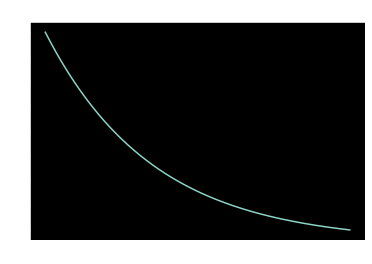

In [16]:
# plot epsilon
# %matplotlib ipympl
%matplotlib inline
plt.figure()
plt.style.use('dark_background')
plt.title("epsilon")
plt.plot([get_epsilon(i) for i in range(1000000) if get_epsilon(i) >= 0.1])
plt.show()

In [17]:
def get_action(obs: Tensor, epsilon: float) -> int:
    if random.random() < epsilon:
        return env.action_space.sample()
    state_batch = obs.unsqueeze(0)
    policy.eval()
    with torch.no_grad():
        q_values = policy(state_batch)
    return int(q_values.argmax(dim=1).squeeze()) # return action with highest q-value

In [18]:
def test(render=False, seed:int=42) -> Tuple[bool, float]:
    if render:
        env = make_env(render_mode="human")
    else:
        env = make_env()
    assert env.spec.reward_threshold is not None
    obs, info = env.reset(seed=seed)
    obs = torch.as_tensor(obs, dtype=torch.float32)
    episode_reward = 0
    for i in count():
        action = get_action(obs, 0)
        obs, reward, done, trunc, info = env.step(action)
        obs = torch.as_tensor(obs, dtype=torch.float32)
        episode_reward += reward
        if render:
            env.render()
        if done or trunc:
            break
    return episode_reward >= env.spec.reward_threshold, episode_reward

In [26]:
assert not test()[0], "untrained model should probably not be able to solve the environment"
assert np.array_equal(test()[1], test()[1]), "tests should be performed with the same seed"

c:\Users\TeamD\.conda\envs\tianshou\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
c:\Users\TeamD\.conda\envs\tianshou\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [20]:
# step metrics
loss_history: List[float] = []
learning_rate_history: List[float] = []
reward_history: List[float] = []
duration_history: List[int] = []
action_history: List[int] = []
terminal_history: List[bool] = []
# other metrics
test_reward_history: List[Tuple[int, float, float]] = []
last_episode_reward = 0

In [21]:
optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(policy.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    # mode="max",
    mode="min",
    factor=0.9,
    patience=500,
    cooldown=500,
    min_lr=0.00001,
    verbose=True,
)
steps_done = 0

In [22]:
TRAIN_EPISODES = 1000
solved = False
with tqdm(total=TRAIN_EPISODES, dynamic_ncols=True, ascii=True) as pbar:
    for episode in range(TRAIN_EPISODES):
        if solved: break
        state = torch.as_tensor(env.reset(seed=random.randint(0,100000))[0], dtype=torch.float32)
        episode_reward = 0
        for episode_step in count():
            epsilon = get_epsilon(steps_done)
            #region exploration
            action = get_action(state, epsilon)
            action_history.append(action)
            next_state, reward, done, trunc, info = env.step(action)
            episode_reward += reward
            reward_history.append(reward)
            terminal_history.append(done)
            if done or trunc:
                duration_history.append(episode_step)
                next_state = torch.zeros(state.shape)
            else:
                next_state = torch.as_tensor(next_state, dtype=torch.float32)                
            memory.append(Transition(
                observation=state,
                action=action,
                reward=reward,
                next_state=next_state,
                finished=done or trunc,
            ))
            state = next_state

            PREVIEW_EPISODE_INTERVAL = 10
            if episode % PREVIEW_EPISODE_INTERVAL == 0:
                env.render()
            #endregion exploration

            #region training
            BATCH_SIZE = 128
            if len(memory) < BATCH_SIZE:
                pbar.set_description(f"warmup")
            else:
                policy.train()
                batch = sample_memory(BATCH_SIZE)

                # calculate q values for the actions that were taken
                q_pred = policy(batch.observations).gather(1, batch.actions.unsqueeze(1))

                # calculate q values for next state
                q_next = torch.zeros(BATCH_SIZE)
                non_final = ~batch.finished
                q_next[non_final] = policy_target(batch.next_states[non_final]).max(dim=1).values.detach()

                # calculate expected q values
                REWARD_GAMMA = 0.99
                q_expected = ((q_next * REWARD_GAMMA) + batch.rewards).unsqueeze(1)

                # calculate loss
                # criterion = torch.nn.SmoothL1Loss()
                # criterion = torch.nn.MSELoss()
                policy_loss = F.mse_loss(q_pred, q_expected)
                loss_history.append(policy_loss.item())

                # apply weight update
                optimizer.zero_grad()
                policy_loss.backward()
                for param in policy.parameters():
                    assert param.grad is not None
                    param.grad.data.clamp_(-1, 1) 
                optimizer.step()
                
                # update learning rate
                lr = optimizer.param_groups[0]["lr"]
                learning_rate_history.append(lr)
                scheduler.step(policy_loss)

                ## update target network
                
                SOFT_UPDATE_TAU = 0.001  
                # soft_update(policy_target, policy, SOFT_UPDATE_TAU)
                POLICY_TARGET_UPDATE_INTERVAL = 10 
                if steps_done % POLICY_TARGET_UPDATE_INTERVAL == 0:
                    hard_update(policy_target, policy)

                #region testing
                TEST_INTERVAL = 500
                if steps_done % TEST_INTERVAL == 0:
                    tests = list(zip(*[test() for _ in range(5)]))
                    test_passes: List[bool] = tests[0] # type: ignore :P
                    test_rewards: List[float] = tests[1] # type: ignore :P
                    passed = all(test_passes)
                    test_reward_mean = np.mean(test_rewards).item()
                    test_reward_variance = max(max(test_rewards) - test_reward_mean, test_reward_mean - min(test_rewards))
                    best = (0,0,0) if len(test_reward_history) == 0 else max(test_reward_history, key=lambda x: x[1] - x[2])
                    test_reward = f"{test_reward_mean:.3f} ± {test_reward_variance:.3f}"
                    best_reward = f"{best[1]:.3f} ± {best[2]:.3f}"
                    print(f"test reward: {test_reward} (best: {best_reward}, goal: {env.spec.reward_threshold})")
                    last_test_reward = test_reward
                    test_reward_history.append((steps_done, test_reward_mean, test_reward_variance))
                    if passed:
                        print("solved!")
                        solved=True
                        break
                #endregion testing

                pbar.set_description(f"policy: {policy_loss.item():09.3f}, reward: {reward:+07.3f} (last episode: {last_episode_reward:.3f}), epsilon: {epsilon:.3f}, lr: {lr:.7f}, steps: {steps_done}")
            #endregion training

            steps_done += 1

            if done or trunc: break

        last_episode_reward = episode_reward
        pbar.update()

policy: 00092.999, reward: -08.000 (last episode: -188.000), epsilon: 0.857, lr: 0.0010000, steps: 521:   2%|2         | 20/1000 [00:04<03:33,  4.59it/s]

test reward: -247.000 ± 0.000 (best: 0.000 ± 0.000, goal: -45)


policy: 00121.680, reward: -10.000 (last episode: -297.000), epsilon: 0.817, lr: 0.0010000, steps: 1025:   4%|3         | 39/1000 [00:09<03:32,  4.53it/s]

test reward: -247.000 ± 0.000 (best: -247.000 ± 0.000, goal: -45)


policy: 00069.643, reward: -09.000 (last episode: -191.000), epsilon: 0.780, lr: 0.0010000, steps: 1526:   6%|5         | 58/1000 [00:14<03:28,  4.51it/s]

test reward: -247.000 ± 0.000 (best: -247.000 ± 0.000, goal: -45)


policy: 00138.475, reward: -09.000 (last episode: -278.000), epsilon: 0.773, lr: 0.0009000, steps: 1613:   6%|6         | 62/1000 [00:15<05:09,  3.03it/s]

Epoch 01461: reducing learning rate of group 0 to 9.0000e-04.


policy: 00100.421, reward: -06.000 (last episode: -215.000), epsilon: 0.744, lr: 0.0009000, steps: 2027:   8%|7         | 77/1000 [00:19<03:29,  4.41it/s]

test reward: -241.000 ± 0.000 (best: -247.000 ± 0.000, goal: -45)


policy: 00266.901, reward: -06.000 (last episode: -256.000), epsilon: 0.710, lr: 0.0009000, steps: 2528:  10%|9         | 97/1000 [00:24<03:20,  4.51it/s]

test reward: -247.000 ± 0.000 (best: -241.000 ± 0.000, goal: -45)


policy: 00213.499, reward: -08.000 (last episode: -221.000), epsilon: 0.705, lr: 0.0008100, steps: 2603:  10%|#         | 100/1000 [00:25<02:53,  5.19it/s]

Epoch 02462: reducing learning rate of group 0 to 8.1000e-04.


policy: 00538.998, reward: -04.000 (last episode: -254.000), epsilon: 0.678, lr: 0.0008100, steps: 3026:  12%|#1        | 116/1000 [00:29<03:39,  4.03it/s]

test reward: -247.000 ± 0.000 (best: -241.000 ± 0.000, goal: -45)


policy: 00793.292, reward: -10.000 (last episode: -235.000), epsilon: 0.647, lr: 0.0008100, steps: 3525:  14%|#3        | 135/1000 [00:34<03:42,  3.89it/s]

test reward: -221.000 ± 0.000 (best: -241.000 ± 0.000, goal: -45)


policy: 00430.508, reward: -08.000 (last episode: -275.000), epsilon: 0.642, lr: 0.0007290, steps: 3615:  14%|#3        | 139/1000 [00:34<02:51,  5.02it/s]

Epoch 03463: reducing learning rate of group 0 to 7.2900e-04.


policy: 01728.174, reward: -11.000 (last episode: -213.000), epsilon: 0.618, lr: 0.0007290, steps: 4026:  15%|#5        | 154/1000 [00:39<04:00,  3.52it/s]

test reward: -221.000 ± 0.000 (best: -221.000 ± 0.000, goal: -45)


policy: 00404.082, reward: -09.000 (last episode: -219.000), epsilon: 0.591, lr: 0.0007290, steps: 4524:  17%|#7        | 174/1000 [00:44<03:52,  3.55it/s]

test reward: -247.000 ± 0.000 (best: -221.000 ± 0.000, goal: -45)


policy: 00710.426, reward: -08.000 (last episode: -256.000), epsilon: 0.586, lr: 0.0006561, steps: 4615:  18%|#7        | 177/1000 [00:44<03:02,  4.52it/s]

Epoch 04464: reducing learning rate of group 0 to 6.5610e-04.


policy: 00342.232, reward: -08.000 (last episode: -218.000), epsilon: 0.564, lr: 0.0006561, steps: 5025:  19%|#9        | 193/1000 [00:49<04:19,  3.11it/s]

test reward: -247.000 ± 0.000 (best: -221.000 ± 0.000, goal: -45)


policy: 00826.226, reward: -10.000 (last episode: -225.000), epsilon: 0.542, lr: 0.0006561, steps: 5461:  21%|##1       | 210/1000 [00:53<03:21,  3.93it/s]


KeyboardInterrupt: 

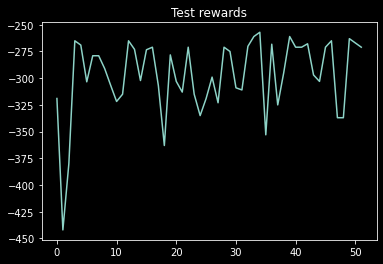

In [ ]:
# plot rewards
plt.figure()
plt.plot([x[1]-x[2] for x in test_reward_history])
plt.title("Test rewards")
plt.show()

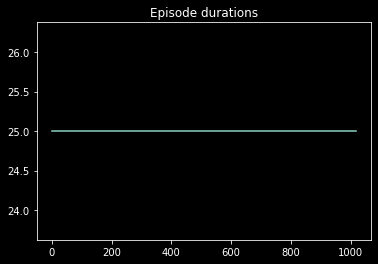

In [ ]:
# plot durations
plt.figure()
plt.plot(duration_history)
plt.title("Episode durations")
plt.show()

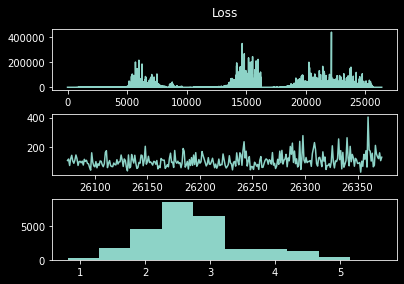

In [ ]:
# plot loss
fig, axs = plt.subplots(3)
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    # wspace=0.4,
    hspace=0.4,
)
fig.suptitle("Loss")
axs[0].plot(loss_history)
axs[1].plot(range(len(loss_history))[-300:], loss_history[-300:])
axs[2].hist(np.log10(loss_history))
plt.show()

In [ ]:
# investigate actions
import ipywidgets as widgets
plt.figure()
@widgets.interact(i=(0, len(action_history)-1), window_size=(1, len(action_history)-1))
def preview_actions(i=len(action_history)-100, window_size=100):
    x = torch.zeros((len(action_history), env.action_space.n + 1))
    x[range(len(action_history)), action_history] = 1
    x[:, 2] = torch.as_tensor(terminal_history, dtype=torch.bool)
    plt.imshow(x[i:i+window_size], aspect="auto")
    plt.show()
    del x

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=26401, description='i', max=26500), IntSlider(value=100, description='wi…

In [ ]:
# preview
epsilon = 0
for episode in range(5):
    success, reward = test(render=True)
    print(f"success={success}, reward={reward}")

c:\Users\TeamD\.conda\envs\tianshou\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
c:\Users\TeamD\.conda\envs\tianshou\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


success=False, reward=-247
success=False, reward=-247
success=False, reward=-247
success=False, reward=-263
success=False, reward=-265
success=False, reward=-247
success=False, reward=-291
success=False, reward=-261
success=False, reward=-269
success=False, reward=-221
success=False, reward=-247
success=False, reward=-319
success=False, reward=-309
success=False, reward=-247
success=False, reward=-247
success=False, reward=-247
success=False, reward=-247
success=False, reward=-247
success=False, reward=-247


KeyboardInterrupt: 